# New

## Objectives


### Imports

In [19]:
import logging
import matplotlib.pyplot as plt
import numpy as np

from PySONIC.core import PulsedProtocol
from PySONIC.neurons import getPointNeuron
from PySONIC.utils import logger, si_format
from ExSONIC.core import IintraFiber, IntracellularCurrent, unmyelinatedFiberSundt, unmyelinatedFiberConvergence
from ExSONIC.plt import SectionCompTimeSeries, strengthDurationCurve

logger.setLevel(logging.INFO)

### Fiber model and stimulation parameters

In [20]:
# Sundt unmyelinated fiber model 
fiber = unmyelinatedFiberSundt(IintraFiber)

# Stimulation parameters: intracellular electrical stimulation
psource = IntracellularCurrent(fiber.nnodes // 2)
durations = np.logspace(-5, 0, 10)  # s
toffset = 10e-3  # s

In [18]:
logger.info(f'Running titration for {si_format(pp.tstim)}s pulse')
logger.setLevel(logging.WARNING)
Ithr = fiber.titrate(psource, pp)  # A
logger.setLevel(logging.INFO)
print(Ithr)

 03/12/2019 14:02:08: Running titration for 1 ms pulse


1.1364435341230113e-10


### Strength-duration curve

In [ ]:
# Compute and plot strength-duration curve for intracellular injection at central node
durations = np.logspace(-5, 0, 10)  # s
Ithrs_sim = np.array([fiber.titrate(psource, PulsedProtocol(x, toffset)) for x in durations])  # A
Qthrs_sim = Ithrs_sim * durations  # C

In [ ]:
        # Compute SD curves metrics
        SDcurve_sim_metrics = {
            'chr': chronaxie(durations, Ithrs_sim),  # s
            'tau_e': Qthrs_sim.min() / Ithrs_sim.min()  # s
        }

        # Plot strength-duration curve
        fig2 = strengthDurationCurve(fiber, durations, {'sim': Ithrs_sim}, yfactor=1e9, scale='log')

        logger.info(f'Comparing metrics for {si_format(pp.tstim)}s intracellular anodic pulse')
        self.logOutputMetrics(pulse_sim_metrics, pulse_ref_metrics)
        logger.info(f'Computing strength-duration curve metrics')
        self.logOutputMetrics(SDcurve_sim_metrics)

 03/12/2019 12:09:03: IintraFiber(sundt neuron, 101 nodes, rs = 100 Ohm.cm, nodeD = 800.0 nm, nodeL = 49.5 um, interD = 800.0 nm, interL = 0.0 m): simulation @ IntracellularCurrent(node 50), I = 136.37 pA, 1.0 ms stim, 15.0 ms offset


cv = 0.43 m/s
dV = 86.96 m/s


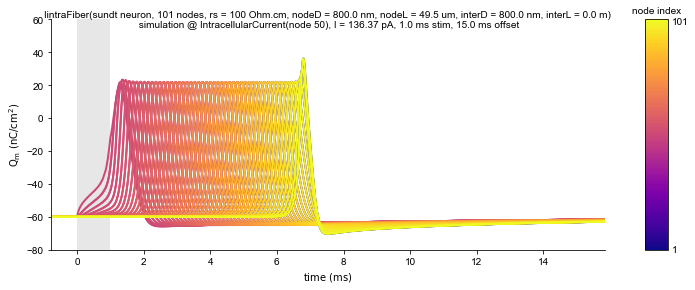

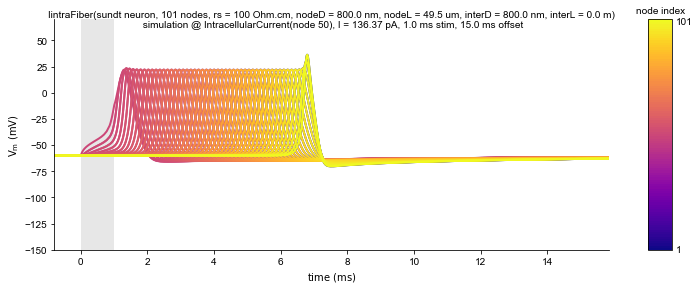

In [8]:
data, meta = fiber.simulate(psource, 1.2 * Ithr, pp)
fig1 = SectionCompTimeSeries([(data, meta)], 'Qm', fiber.ids).render()
fig2 = SectionCompTimeSeries([(data, meta)], 'Vm', fiber.ids).render()
print(f'cv = {fiber.getConductionVelocity(data, out="median"):.2f} m/s')
print(f'dV = {fiber.getSpikeAmp(data, out="median"):.2f} m/s')

### Run convergence and load results

In [15]:
df = unmyelinatedFiberConvergence(pneuron, fiberD, rs, fiberL, maxNodeL_range, pp, outdir='.')
cols = list(df.columns)
nodeL_range = df['nodeL (m)'] * 1e6
outs = cols[2:]

df.head(3)

 03/12/2019 12:11:27: loading results from log file


,maxNodeL (m),nodeL (m),Ithr (A),CV (m/s),dV (mV)
0,0.001000,0.001000,NaN,NaN,NaN
1,0.000955,0.000714,NaN,NaN,NaN
2,0.000911,0.000714,NaN,NaN,NaN


### Evaluate errors

In [4]:
eps_thr = 0.05
eps = {}
nodeL_thr = {}
for i, k in enumerate(outs):
    x = df[k].values
    xref = x[-1]
    eps[k] = np.abs((x - xref) / xref)
    nodeL_thr[k] = np.interp(eps_thr, eps[k][::-1], nodeL_range[::-1], left=np.nan, right=np.nan)
logger.info(f'Relative error threshold = {eps_thr * 1e2:.1f} %')
logger.info(f'Max node length = {min(nodeL_thr.values()):.2f} um')

 27/11/2019 18:34:37: Relative error threshold = 5.0 %
 27/11/2019 18:34:37: Max node length = 52.10 um


### Plot metrics convergence

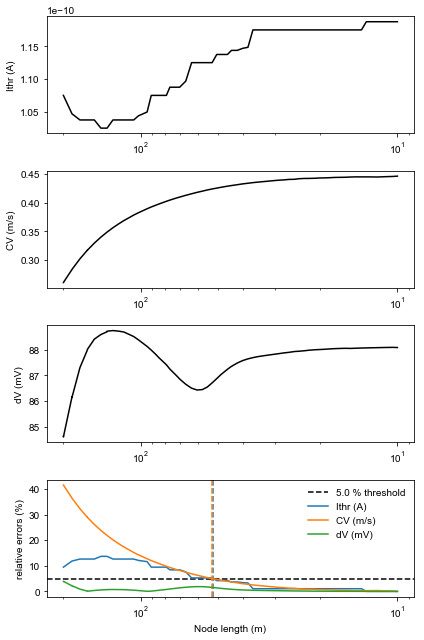

In [5]:
fig, axes = plt.subplots(len(outs) + 1, 1, figsize=(6, 9))
for i, out in enumerate(outs):
    ax = axes[i]
    ax.set_ylabel(out)
    ax.plot(nodeL_range, df[out], c='k')
ax = axes[i + 1]
ax.set_ylabel('relative errors (%)')
ax.axhline(eps_thr * 100, linestyle='dashed', label=f'{eps_thr * 1e2:.1f} % threshold', color='k')
for i, k in enumerate(outs):
    ax.plot(nodeL_range, eps[k] * 100, label=k, c=f'C{i}')
    ax.axvline(nodeL_thr[k], linestyle='dashed', color=f'C{i}')
ax.legend(frameon=False)
axes[-1].set_xlabel('Node length (m)')
for ax in axes:
    ax.set_xscale('log')
    ax.invert_xaxis()
fig.tight_layout()

As we can see, as the node length is decreased, the 3 output metrics converge to specific asymptotic values:
- excitation threshold: 0.117 nA
- conduction velocity: 0.44 m/s
- spike amplitude: 88 mV

Setting a maximum relative error of 5%, we deduce that **a node length of around 50 um is required to achieve a reasonable accuracy**. Such a node length does not heavily compromise the computation time (model construction and simulation within a few seconds).

That number is in accordance with the discretization strategy used in Sundt 2015 (100 segments for a 5 mm long peripheral axon, i.e. 50 um length per segment)

## Simulations

In this section we run simulations with the derived threshold node length and stimulation current 1.2 above the threshold amplitude.

In [8]:
fiber = unmyelinatedFiber(IintraFiber, pneuron, fiberD, rs, fiberL)
psource = IntracellularCurrent(fiber.nnodes // 2)
logger.info(f'Running titration for {si_format(pp.tstim)}s pulse')
logger.setLevel(logging.WARNING)
Ithr = fiber.titrate(psource, pp)  # A
logger.setLevel(logging.INFO)
data, meta = fiber.simulate(psource, 1.2 * Ithr, pp)

 27/11/2019 18:35:23: Running titration for 1 ms pulse
 27/11/2019 18:35:28: IintraFiber(sundt neuron, 101 nodes, rs = 100 Ohm.cm, nodeD = 800.0 nm, nodeL = 49.5 um, interD = 800.0 nm, interL = 0.0 m): simulation @ IntracellularCurrent(node 50), I = 139.20 pA, 1.0 ms stim, 15.0 ms offset


cv = 0.43 m/s
dV = 86.95 m/s


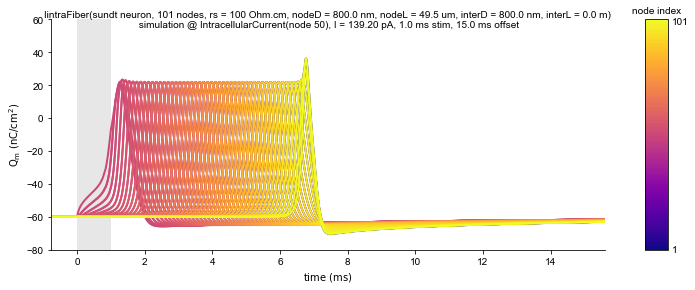

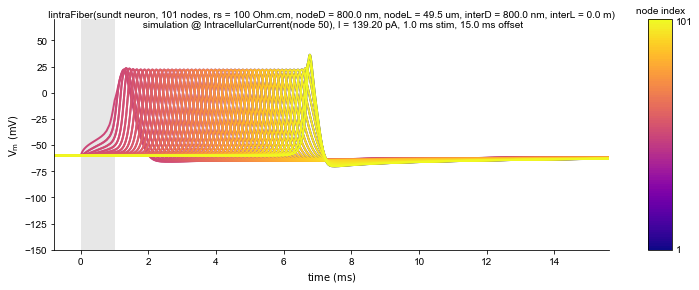

In [9]:
fig1 = SectionCompTimeSeries([(data, meta)], 'Qm', fiber.ids).render()
fig2 = SectionCompTimeSeries([(data, meta)], 'Vm', fiber.ids).render()
print(f'cv = {fiber.getConductionVelocity(data, out="median"):.2f} m/s')
print(f'dV = {fiber.getSpikeAmp(data, out="median"):.2f} m/s')

As we can see, the behavior of the unmyelinated C-fiber model is in good correspondence with the reference literature (Sundt 2015):
- conduction velocity is slightly slower than reported in the paper (0.54 m/s for the peripheral axon) but agrees with ModelDB simulation results
- action potential waveform (ca. 1-2 ms duration, ca. 87 mV amplitude) seems in line with the paper results
- the excitation threshold (0.12 nA) is in line with the just supra-threshold range of 0.2 nA used in the paper to stimulate the peripheral axon

## Strength-duration curve
Let's compute the threshold injected current required to excite the fiber, for various stimulus durations:

In [12]:
fiber.reset()
durations = np.logspace(-5, -1, 10)  # s
logger.setLevel(logging.WARNING)
Ithrs = np.array([fiber.titrate(psource, PulsedProtocol(x, toffset)) for x in durations])
logger.setLevel(logging.INFO)

 25/11/2019 16:08:18: titration does not converge within this interval
 25/11/2019 16:08:24: titration does not converge within this interval


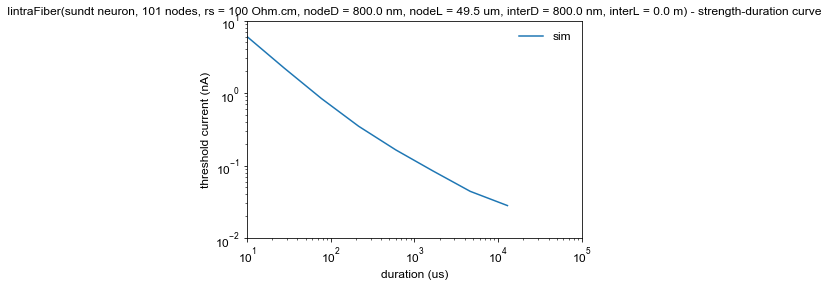

In [13]:
fig = strengthDurationCurve(
    fiber, durations, {'sim': np.array(Ithrs)}, scale='log', plot_chr=False,
    yname='current', yfactor=1e9, yunit='A')

Expectedly, the threshold current required to excite the fiber falls as the stimulus duration increases.

## Conclusions
- The unmyelinated neuron fiber model is implemented
- A maximal node length of about **50 ${\mu}m$** is required to achieve accurate simulations (allowing for a 5% relative error in output metrics)
- Resulting conduction velocity is more than 10 times less than for myelinated fiber
- The strength-duration curve obtained from the simulation data makes empirical sense

## References

- Sundt D, Gamper N, Jaffe DB., *Spike propagation through the dorsal root ganglia in an unmyelinated sensory neuron: a modeling study*, J Neurophysiol 114: 3140–3153, 2015.